# Simulating Grid World using Tensorflow 
### Ref: https://towardsdatascience.com/tf-agents-tutorial-a63399218309

In [1]:
# Environment libraries
from tf_agents.environments import utils
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import wrappers
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
import numpy as np

# Simulation libraries
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment

from tf_agents.trajectories import trajectory
from tf_agents.environments import wrappers

#from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

import matplotlib.pyplot as plt

# Setting up the Grid World Environment

In [2]:
# Declare the starting and ending point of the training
global sx, sy, dx, dy
sx, sy, dx, dy = 5, 5, 3, 3
sxold, syold = 5, 5

In [3]:
class GridWorldEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(4,), dtype=np.int32, minimum=[0,0,0,0],maximum=[5,5,5,5], name='observation')
        
        self._state=[sx, sy, dx, dy] #represent the (row, col, frow, fcol) of the player and the finish
        self._steps = 0
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state= [sx, sy, dx, dy]
        self._steps = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):
        
        self._steps += 1

        if (self._steps > 90):
            self._episode_ended = True
                
        if self._episode_ended:
            return self.reset()

        # make a move
        self.move(action)
                
        if self.game_over():
            self._episode_ended = True

        if self._episode_ended:
            if self.game_over():
                reward = 100
            else:
                reward = 0
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            # give a negative reward in general
            return ts.transition(
                np.array(self._state, dtype=np.int32), reward=-0.1 * self.currdist(), discount=0.9)

    def move(self, action):
        row, col, frow, fcol = self._state[0],self._state[1],self._state[2],self._state[3]
        if action == 0: #down
            if row - 1 >= 0:
                self._state[0] -= 1
        if action == 1: #up
            if row + 1 < 6:
                self._state[0] += 1
        if action == 2: #left
            if col - 1 >= 0:
                self._state[1] -= 1
        if action == 3: #right
            if col + 1  < 6:
                self._state[1] += 1

    def game_over(self):
        row, col, frow, fcol = self._state[0],self._state[1],self._state[2],self._state[3]
        return row==frow and col==fcol
    
    def currdist(self):
        row, col, frow, fcol = self._state[0],self._state[1],self._state[2],self._state[3]
        return (abs(row-frow) + abs(col-fcol))

In [4]:
env = GridWorldEnv()
utils.validate_py_environment(env, episodes=5)
print ('Grid world is validated')

Grid world is validated


In [5]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([5, 5, 3, 3]),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})

# Declaring the environment for the first time 

In [6]:
## Writing a function to declare the environment
def declareenv(ox=sx, oy=sy):
        
    global sx, sy
    sxold, syold = sx, sy
    sx, sy = ox, oy 
    print ('new sx and sy are', sx, sy)
    
    train_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)
    print (train_env.reset())
    
    # reset back
    #sx, sy = sxold, syold
    
    return (train_env)

for i in range(6):
    for j in range(6):
        train_env = declareenv(i,j)
        print (i, j )
        print (train_env.reset())

In [7]:
train_env = declareenv()
eval_env = declareenv()

# Evaluate a few things
print (train_env.action_spec())
print (train_env.observation_spec())
print (train_env.time_step_spec())
print (train_env.reset())

new sx and sy are 5 5
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[5, 5, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
new sx and sy are 5 5
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[5, 5, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0), maximum=array(3))
BoundedTensorSpec(shape=(4,), dtype=tf.int32, name='observation', minimum=array([0, 0, 0, 0]), maximum=array([5, 5, 5, 5]))
TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.f

# Set up the simulation run 

In [8]:
# Compute average return 
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [9]:
# Set Parameters
num_iterations = 10000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 10000  # @param

fc_layer_params = (50,25)

batch_size = 128  # @param
learning_rate = 1e-5  # @param
log_interval = 200  # @param

num_eval_episodes = 2  # @param
eval_interval = 1000  # @param

# Setting up the agent

In [10]:
# Set up the Q network
q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

# Set up the optimizer
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.optimizers.SGD (learning_rate=0.001, name='SGD')

train_step_counter = tf.compat.v2.Variable(0)

# Set up the agent
tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn = common.element_wise_squared_loss,  #dqn_agent.element_wise_squared_loss,
        train_step_counter=train_step_counter)

tf_agent.initialize()

In [11]:
# Set up the policy
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity)

print("Batch Size: {}".format(train_env.batch_size))

# Create reply observer
replay_observer = [replay_buffer.add_batch]

# Train metrics
train_metrics = [
            tf_metrics.NumberOfEpisodes(),
            tf_metrics.EnvironmentSteps(),
            tf_metrics.AverageReturnMetric(),
            tf_metrics.AverageEpisodeLengthMetric(),
]

Batch Size: 1


In [12]:
# Collect trajectories
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)
    
# Set up the datastep and driver
dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [13]:
# Some prints
episode_len = []
step_len = []

# Training Loop

In [14]:
tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [15]:
def onerun(env, episode_len, step_len):
    
    driver = dynamic_step_driver.DynamicStepDriver(
            train_env,
            collect_policy,
            observers=replay_observer + train_metrics,
    num_steps=1)

    print(compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes))

    final_time_step, policy_state = driver.run()

    for i in range(100):
        final_time_step, _ = driver.run(final_time_step, policy_state)
    
    for i in range(num_iterations):
        final_time_step, _ = driver.run(final_time_step, policy_state)
        #for _ in range(1):
        #    collect_step(train_env, tf_agent.collect_policy)

        experience, _ = next(iterator)
        train_loss = tf_agent.train(experience=experience)
        step = tf_agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss.loss))
            episode_len.append(train_metrics[3].result().numpy())
            step_len.append(step)
            print('Average episode length: {}'.format(train_metrics[3].result().numpy()))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))


    return (episode_len, step_len)

In [16]:
#training 1: 
tuples = [(0,0), (5, 5), (0, 5), (5, 0)]

#training 2:
#tuples = [(0,0)]

for t in tuples:
    i, j = t[0], t[1]
    print ('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print (i, j)
    train_env = declareenv(i, j)
    print (train_env.reset())
    print ('###############################')
    episode_len, step_len = onerun(train_env, episode_len, step_len)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0 0
new sx and sy are 0 0
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 0, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 0, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
###############################
-2478.0042
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(f

step = 14600: loss = 0.9238119721412659
Average episode length: 5.300000190734863
step = 14800: loss = 6.723039627075195
Average episode length: 4.5
step = 15000: loss = 0.4575493335723877
Average episode length: 4.400000095367432
step = 15000: Average Return = 98.0
step = 15200: loss = 0.4555986523628235
Average episode length: 4.199999809265137
step = 15400: loss = 0.15301746129989624
Average episode length: 4.599999904632568
step = 15600: loss = 0.6111154556274414
Average episode length: 4.300000190734863
step = 15800: loss = 0.7357653379440308
Average episode length: 4.099999904632568
step = 16000: loss = 0.49535736441612244
Average episode length: 4.599999904632568
step = 16000: Average Return = 98.0
step = 16200: loss = 3.317345142364502
Average episode length: 4.900000095367432
step = 16400: loss = 1.6855541467666626
Average episode length: 4.400000095367432
step = 16600: loss = 0.7688202261924744
Average episode length: 4.400000095367432
step = 16800: loss = 2.866004467010498
A

96.0
step = 30200: loss = 0.08693812787532806
Average episode length: 6.400000095367432
step = 30400: loss = 0.1554965078830719
Average episode length: 6.0
step = 30600: loss = 0.04752624034881592
Average episode length: 5.0
step = 30800: loss = 0.2262679934501648
Average episode length: 5.400000095367432
step = 31000: loss = 0.057239532470703125
Average episode length: 5.0
step = 31000: Average Return = 96.0
step = 31200: loss = 0.06747006624937057
Average episode length: 5.900000095367432
step = 31400: loss = 0.26258763670921326
Average episode length: 5.199999809265137
step = 31600: loss = 0.06060093641281128
Average episode length: 5.5
step = 31800: loss = 0.12347622960805893
Average episode length: 5.099999904632568
step = 32000: loss = 0.0507042333483696
Average episode length: 5.199999809265137
step = 32000: Average Return = 96.0
step = 32200: loss = 0.054427433758974075
Average episode length: 5.400000095367432
step = 32400: loss = 0.21645867824554443
Average episode length: 5.

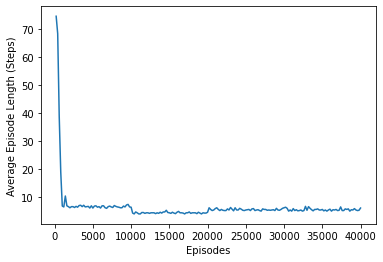

In [17]:
plt.plot(step_len, episode_len)
plt.xlabel('Episodes')
plt.ylabel('Average Episode Length (Steps)')
plt.show()

# Evaluate if learnt policy is useful, by starting from different states

##### Workaround to give a new starting point

1. Four global variables, sx, sy, dx, dy are defined at the start of the simulation. 
2. Based on the required starting point these global sx and sy are modifed and environment is created
3. After the simulation run, sx ,sy are reset to old state

In [18]:
def newstartpoint(startpos):
    '''
    function to simulate starting from a required location
    '''
    global sx, sy
    sxold, syold = sx, sy
    # changing the global variables sx, sy that are used to declare environment
    print ('previous values of global variables sx, sy are', sx, sy)
    
    sx = startpos[0]
    sy = startpos[1]
    
    print ('new values of global variables sx, sy are', sx, sy)
    

    # declare a new tf env starting with Py env 
    check_py_env = wrappers.TimeLimit(GridWorldEnv(), duration=100)
    check_env = tf_py_environment.TFPyEnvironment(check_py_env)
    
    # reset new environment
    newenv = check_env
    time_step = newenv.reset()
    #time_step = newenv.set_state(startpos[0], startpos[1])
    print (time_step)
    
    nsteps = 0
    #run in loop
    while not time_step.is_last():
        action = tf_agent.policy.action(time_step)
        print ('action take is', action.action)
        time_step = newenv.step(action.action)
        nsteps +=1
        print ('new time step is', time_step)
    
    print ('time steps to reach destination from starpos is', nsteps)
    
    
    # resetting sx and sy
        # changing the global variables sx, sy that are used to declare environment
    print ('current values of global variables sx, sy are', sx, sy)
    
    sx, sy = sxold, syold 
    
    print ('updated values of global variables sx, sy are', sx, sy)
    
    return nsteps

In [19]:
marklst = []
for i in range(6):
    for j in range(6):
        nsteps = newstartpoint([i,j])
        marklst.append([i, j, nsteps])
        
print (marklst)

previous values of global variables sx, sy are 5 0
new values of global variables sx, sy are 0 0
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 0, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
action take is tf.Tensor([1], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[1, 0, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.5], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([3], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9],

new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2, 2, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([3], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([1], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy

action take is tf.Tensor([2], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[1, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([1], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([1], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'obs

new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})
action take is tf.Tensor([1], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[3, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>})
time steps to reach destination from starpos is 2
current values of global variables sx, sy are 2 4
updated values of global variables sx, sy are 5 0
previous values of global variables sx, sy are 5 0
new values of global variable

action take is tf.Tensor([2], shape=(1,), dtype=int32)
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[3, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>})
time steps to reach destination from starpos is 1
current values of global variables sx, sy are 3 4
updated values of global variables sx, sy are 5 0
previous values of global variables sx, sy are 5 0
new values of global variables sx, sy are 3 5
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[3, 5, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
act

new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[3, 3, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([100.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>})
time steps to reach destination from starpos is 4
current values of global variables sx, sy are 5 1
updated values of global variables sx, sy are 5 0
previous values of global variables sx, sy are 5 0
new values of global variables sx, sy are 5 2
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[5, 2, 3, 3]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})
action take is tf.Tensor([0], shape=(1,), dtype=int32)
new

In [20]:
marklst

[[0, 0, 6],
 [0, 1, 5],
 [0, 2, 4],
 [0, 3, 3],
 [0, 4, 4],
 [0, 5, 5],
 [1, 0, 5],
 [1, 1, 4],
 [1, 2, 3],
 [1, 3, 2],
 [1, 4, 3],
 [1, 5, 4],
 [2, 0, 4],
 [2, 1, 3],
 [2, 2, 2],
 [2, 3, 1],
 [2, 4, 2],
 [2, 5, 3],
 [3, 0, 3],
 [3, 1, 2],
 [3, 2, 1],
 [3, 3, 2],
 [3, 4, 1],
 [3, 5, 2],
 [4, 0, 4],
 [4, 1, 3],
 [4, 2, 2],
 [4, 3, 1],
 [4, 4, 2],
 [4, 5, 3],
 [5, 0, 5],
 [5, 1, 4],
 [5, 2, 3],
 [5, 3, 2],
 [5, 4, 3],
 [5, 5, 4]]